**STEP 1:** Data Exploration

In [159]:
import json

# Load the training data
with open('/Users/mennodevries/Documents/Master Data Science/Machine Learning/Assignment/train.json', 'r') as file:
    train_data = json.load(file)

# Load the test data
with open('/Users/mennodevries/Documents/Master Data Science/Machine Learning/Assignment/test.json', 'r') as file:
    test_data = json.load(file)

# Display the first few entries of the training data and the test data
train_data[:3], test_data[:3]

([{'ENTRYTYPE': 'inproceedings',
   'title': 'Philippine Language Resources: Trends and Directions',
   'editor': None,
   'year': '2009',
   'publisher': 'Association for Computational Linguistics',
   'author': ['Roxas, Rachel Edita', 'Cheng, Charibeth', 'Lim, Nathalie Rose'],
   'abstract': None},
  {'ENTRYTYPE': 'inproceedings',
   'title': 'A System for Translating Locative Prepositions From English Into French',
   'editor': None,
   'year': '1991',
   'publisher': 'Association for Computational Linguistics',
   'author': ['Japkowicz, Nathalie', 'Wiebe, Janyce M.'],
   'abstract': None},
  {'ENTRYTYPE': 'inproceedings',
   'title': 'Introduction to the Shared Task on Comparing Semantic Representations',
   'editor': None,
   'year': '2008',
   'publisher': 'College Publications',
   'author': ['Bos, Johan'],
   'abstract': None}],
 [{'ENTRYTYPE': 'inproceedings',
   'title': 'Learning to lemmatise Polish noun phrases',
   'editor': None,
   'publisher': 'Association for Computati

**STEP 1:** Data Exploration

*Features*

- ENTRYTYPE: The type of publication (e.g., "inproceedings").

- title: The title of the paper.

- editor: The editor of the paper (if any).

- year: The year of publication (only in the training data).

- publisher: The publisher of the paper.

- author: The author(s) of the paper.

- abstract: The abstract of the paper (if any).



*Unique values*

- ENTRYTYPE: 3 unique values

- title: 65,314 unique values

- editor: 1,277 unique values

- year: 62 unique values

- publisher: 120 unique values

- author: 54,313 unique values

- abstract: 32,263 unique values

**Step 2:** Preprocessing the data

*2.1: Check frequency of missing values*

In [161]:
import pandas as pd

# Convert the loaded JSON data into pandas DataFrames for easier manipulation
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Check for missing values in the training data
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()

print(missing_values_train)
print()
print(missing_values_test)

ENTRYTYPE        0
title            0
editor       64438
year             0
publisher     8201
author        2399
abstract     33531
dtype: int64

ENTRYTYPE        0
title            0
editor       21479
publisher     2813
author         831
abstract     11278
dtype: int64


**Remove exact duplicates**

Given that the abstract and editor fields have a large number of missing values, it might not be feasible to fill them with placeholder values. Instead, we can create binary features indicating whether the abstract or editor is missing, which might capture information relevant to the year of publication.

For the author and publisher fields, which have fewer missing values, we could consider filling in missing data with a placeholder such as "Unknown" or using a similar binary feature approach.

The ENTRYTYPE and title fields have no missing values, which is good news since they can be used directly for feature extraction.

Next, we will handle the missing values as described and encode the ENTRYTYPE field as it is a categorical variable. The title will be processed later with text processing techniques.

*2.2: Encoding*

In [162]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define a function for preprocessing and tokenization
def preprocess_and_tokenize(text):
    # Check if the text is a string (to handle NaNs and None)
    if not isinstance(text, str):
        return []
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()] # added word.isalpha() to filter out punctuation
    return filtered_tokens

# Apply the function to the 'title' and 'abstract' columns of your DataFrame
train_df['title_tokens'] = train_df['title'].apply(preprocess_and_tokenize)
train_df['abstract_tokens'] = train_df['abstract'].apply(preprocess_and_tokenize)

# Apply the preprocessing and tokenization function to the test data
test_df['title_tokens'] = test_df['title'].apply(preprocess_and_tokenize)
test_df['abstract_tokens'] = test_df['abstract'].apply(preprocess_and_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mennodevries/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mennodevries/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
from collections import Counter

def get_most_common_words_per_year(df, column, n=3):
    common_words_per_year = {}
    for year in df['year'].unique():
        words = []
        for text in df[column]:
            words.extend(text)
        common_words = Counter(words).most_common(n)
        common_words_per_year[year] = [word[0] for word in common_words]
    return common_words_per_year

# Get most common words in titles and abstracts per year
common_words_per_year = get_most_common_words_per_year(train_df, 'title_tokens')

# Function to check if all top words for a year are in a paper's title/abstract
def contains_all_top_words(row, top_words, column):
    return all(word in row[column] for word in top_words)

# Create and populate the columns
for year, words in common_words_per_year.items():
    column_name = f"common_words{year}"
    train_df[column_name] = train_df.apply(lambda row: contains_all_top_words(row, words, 'title_tokens') and contains_all_top_words(row, words, 'abstract_tokens'), axis=1)
    test_df[column_name] = test_df.apply(lambda row: contains_all_top_words(row, words, 'title_tokens') and contains_all_top_words(row, words, 'abstract_tokens'), axis=1)

In [164]:
# Explode the 'author' column in the training data
exploded_train_df = train_df.explode('author')

# Calculate the publication count per author
author_pub_count = exploded_train_df.groupby('author').size()

# Map the publication count to the exploded training dataframe and then group by the original index to get the maximum count per paper
train_df['author_pub_frequency'] = (
    exploded_train_df['author']
    .map(author_pub_count)
    .groupby(level=0)
    .max()  # Max frequency per original index
    .reindex(train_df.index)  # Ensure the indices match the original train_df
    .fillna(0)  # Fill NaNs for authors not seen in the exploded_train_df
)

# Apply the same process to the test data
exploded_test_df = test_df.explode('author')
test_df['author_pub_frequency'] = (
    exploded_test_df['author']
    .map(author_pub_count)
    .groupby(level=0)
    .max()  # Max frequency per original index
    .reindex(test_df.index)  # Ensure the indices match the original test_df
    .fillna(0)  # Fill NaNs for authors not seen in the training data
)




# Handling missing values by filling them with a placeholder or creating binary indicators
train_df['editor_missing'] = train_df['editor'].isnull().astype(int)
test_df['editor_missing'] = test_df['editor'].isnull().astype(int)

train_df['abstract_missing'] = train_df['abstract'].isnull().astype(int)
test_df['abstract_missing'] = test_df['abstract'].isnull().astype(int)

train_df['publisher'].fillna('Unknown', inplace=True)
test_df['publisher'].fillna('Unknown', inplace=True)

# Count the number of authors
train_df['num_authors'] = train_df['author'].apply(lambda x: len(x) if isinstance(x, list) else 1)
test_df['num_authors'] = test_df['author'].apply(lambda x: len(x) if isinstance(x, list) else 1)

# Handling missing values for 'author' by filling them with a placeholder AFTER the count
train_df['author'].fillna('Unknown', inplace=True)
test_df['author'].fillna('Unknown', inplace=True)

train_df = pd.get_dummies(train_df, columns=['publisher'], prefix='publisher')
test_df = pd.get_dummies(test_df, columns=['publisher'], prefix='publisher')



# Function to count number of words in a string
def count_words(text):
    if not isinstance(text, str):
        return 0  # Return 0 if text is not a string (e.g., NaN or None)
    return len(text.split())

# Adding a new column for the number of words in the title
train_df['num_words_title'] = train_df['title'].apply(count_words)
test_df['num_words_title'] = test_df['title'].apply(count_words)

# Adding a new column for the number of words in the abstract
train_df['num_words_abstract'] = train_df['abstract'].apply(count_words)
test_df['num_words_abstract'] = test_df['abstract'].apply(count_words)

# Dropping the original columns for which we've created features or indicators
train_df.drop(['editor', 'abstract', 'author', 'title_tokens', 'abstract_tokens'], axis=1, inplace=True)
test_df.drop(['editor', 'abstract', 'author', 'title_tokens', 'abstract_tokens'], axis=1, inplace=True)

# Encoding the 'ENTRYTYPE' field using one-hot encoding
train_df = pd.get_dummies(train_df, columns=['ENTRYTYPE'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['ENTRYTYPE'], drop_first=True)

# Ensuring both train and test dataframes have the same dummy variable columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Convert the 'year' to numeric in the training data
train_df['year'] = pd.to_numeric(train_df['year'])

In [165]:
# Assuming 'df' is your DataFrame
columns = train_df.columns

# Filter out columns that contain 'common_words'
filtered_columns = [col for col in columns if "common_words" not in col]

# Get the first 10 of these filtered columns
first_10_filtered_columns = filtered_columns[:20]

print(first_10_filtered_columns)


['title', 'year', 'author_pub_frequency', 'editor_missing', 'abstract_missing', 'num_authors', 'publisher_-', 'publisher_?? Not mentionned on TOC', 'publisher_AFCP - ATALA', 'publisher_ATALA', 'publisher_ATALA (Association pour le Traitement Automatique des Langues)', 'publisher_ATALA et AFCP', 'publisher_ATALA/AFCP', 'publisher_AsLing', 'publisher_Asian Federation of Natural Language Processing', 'publisher_Aslib', 'publisher_Aslib Proceedings', 'publisher_Assocation for Computational Linguistics', 'publisher_Association for Computational Linguistics', 'publisher_Association for Computational Linguistics and Chinese Language Processing']


In [166]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65914 entries, 0 to 65913
Columns: 193 entries, title to ENTRYTYPE_proceedings
dtypes: bool(62), float64(1), int64(6), object(1), uint8(123)
memory usage: 15.7+ MB


1. Missing editor and abstract fields have been encoded as binary indicators to capture their presence or absence.

2. Missing publisher and author fields have been filled with the placeholder value "Unknown".

3. The ENTRYTYPE field has been one-hot encoded, resulting in new binary features for each publication type.

4. The training data's year field has been converted to a numeric type.

5. The original editor and abstract columns have been dropped since we've captured the necessary information in binary indicator columns.



For the title field, we will apply text processing techniques next. Before that, we need to consider the author field. It contains lists of authors, which could be processed in several ways:

- Counting the number of authors.

- Encoding the presence of specific prolific authors (if such patterns are found in the data).

***TODO***

Trend Analysis:

Yearly Publication Trends: Plot the number of papers published each year to observe overall trends. Look for patterns like increases or decreases over time.
Trends by Publication Type (ENTRYTYPE): Analyze how the distribution of different types of publications (e.g., conference papers, journal articles) changes over the years.
Categorical Variable Analysis:

Publisher Trends: Examine the frequency of different publishers over time. Are there publishers that have become more prominent or less so in certain periods?
Editor Trends: If you decide to include editor information, you could look for any trends in editors over the years (though the high number of missing values might limit the insights you can gain).
Text Analysis:

Title and Abstract Analysis: Use Natural Language Processing (NLP) techniques to analyze titles and abstracts. Look for changes in the language, topics, or keywords over time. Techniques like word cloud visualizations, TF-IDF analysis, or topic modeling (e.g., LDA) could be useful here.
Author Analysis:

Number of Authors Trend: Investigate if the average number of authors per paper has changed over the years. This might indicate trends in collaboration.
Correlation Analysis:

Explore correlations between different numerical features (like the number of authors) and the publication year. This can help identify which features are most strongly associated with the year of publication.
Outlier Detection:

Identify any outliers in your data. For instance, papers with an unusually high number of authors or those published by exceptionally rare publishers.
Visualizations:

Utilize various plots (like line plots, bar charts, scatter plots) to visualize trends and relationships in the data. Histograms can be useful for understanding the distribution of the publication years and other numerical features.
Remember, the goal of EDA is not only to inform the feature engineering and model selection process but also to gain a deeper understanding of the data's characteristics. This understanding can be invaluable in interpreting your model's results and in communicating your findings.


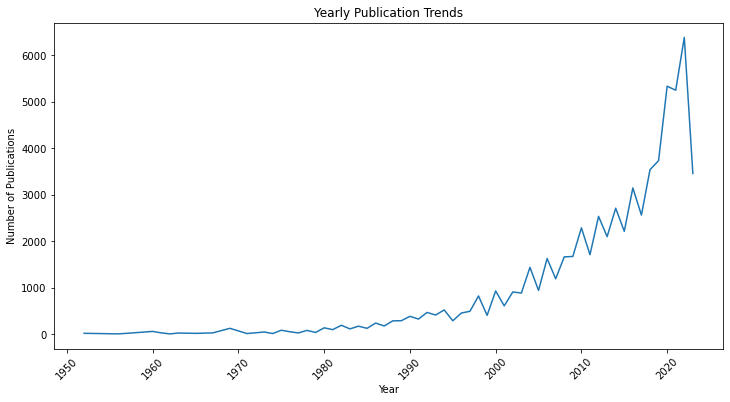

'\n--------- DO SOMETHING ABOUT THIS --------\n'

In [167]:
## Yearly publicaiton trends
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'year' is already converted to numeric in train_df
yearly_counts = train_df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_counts)
plt.title('Yearly Publication Trends')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

"""
--------- DO SOMETHING ABOUT THIS --------
"""

In [168]:
# Counting the number of papers per publication year and sorting
papers_per_year = train_df['year'].value_counts().sort_index()

# Creating a DataFrame from the Series for easy CSV export
papers_per_year_df = papers_per_year.reset_index()
papers_per_year_df.columns = ['Year', 'Number of Papers']

# Exporting to CSV
papers_per_year_df.to_csv('papers_per_year.csv', index=False)


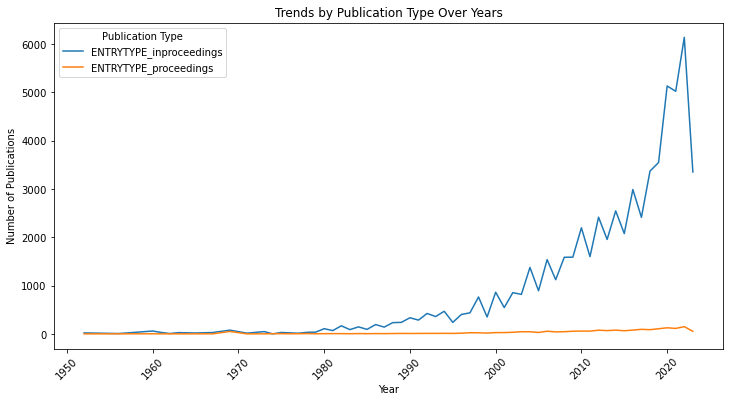

In [169]:
# Assuming you have one-hot encoded 'ENTRYTYPE'
entry_types = [col for col in train_df.columns if 'ENTRYTYPE_' in col]  # Adjust based on your column naming

plt.figure(figsize=(12, 6))
for entry_type in entry_types:
    # Group by year and sum the occurrences of each ENTRYTYPE
    yearly_data = train_df.groupby('year')[entry_type].sum()
    sns.lineplot(data=yearly_data, label=entry_type)

plt.title('Trends by Publication Type Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend(title='Publication Type')
plt.xticks(rotation=45)
plt.show()

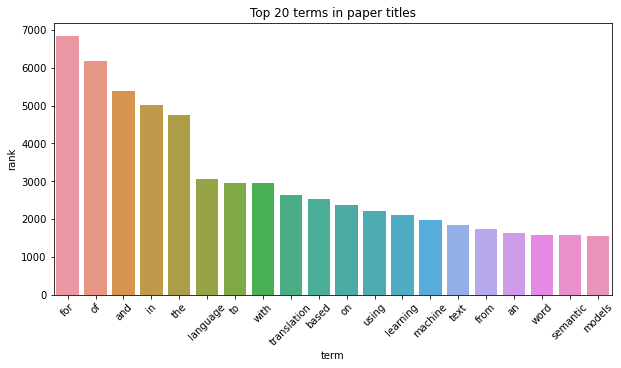

In [170]:
## Text Analysis - Title and Abstract Analysis:

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example using the 'title' column, similar approach can be used for 'abstract'

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # You can adjust the number of features
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['title'].fillna(''))

# Summarizing the TF-IDF scores for each word
sums = tfidf_matrix.sum(axis=0)
data = []
for col, term in enumerate(tfidf_vectorizer.get_feature_names_out()):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Plotting the top terms
plt.figure(figsize=(10, 5))
sns.barplot(x='term', y='rank', data=ranking.head(20))
plt.title('Top 20 terms in paper titles')
plt.xticks(rotation=45)
plt.show()

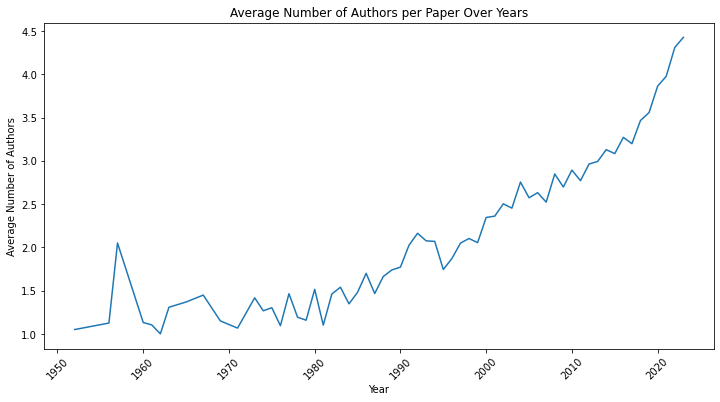

In [171]:
# Author Analysis

# Assuming you already have a 'num_authors' column in your DataFrame
authors_by_year = train_df.groupby('year')['num_authors'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=authors_by_year)
plt.title('Average Number of Authors per Paper Over Years')
plt.xlabel('Year')
plt.ylabel('Average Number of Authors')
plt.xticks(rotation=45)
plt.show()

*2.4: Use NLP technique (TF-IDF) for processing the 'title' feature*

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')

# Combine the titles from train and test datasets to ensure consistent feature set
combined_titles = train_df['title'].tolist() + test_df['title'].tolist()

# Fit the vectorizer on the combined titles
tfidf_vectorizer.fit(combined_titles)

# Transform the titles in the training and test datasets
titles_train_tfidf = tfidf_vectorizer.transform(train_df['title'])
titles_test_tfidf = tfidf_vectorizer.transform(test_df['title'])

# We'll convert the resulting sparse matrices to DataFrames to make them easier to work with
titles_train_tfidf_df = pd.DataFrame(titles_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
titles_test_tfidf_df = pd.DataFrame(titles_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


# Check the shape of the resulting DataFrames
titles_train_tfidf_df.shape, titles_test_tfidf_df.shape

((65914, 2000), (21972, 2000))

*2.5: Concentate TF-IDF features with the other features*

In [173]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
titles_train_tfidf_df = titles_train_tfidf_df.reset_index(drop=True)
titles_test_tfidf_df = titles_test_tfidf_df.reset_index(drop=True)

In [174]:
# Concatenating the TF-IDF features with the original training and test dataframes
train_df_combined = pd.concat([train_df.drop('title', axis=1), titles_train_tfidf_df], axis=1)
test_df_combined = pd.concat([test_df.drop('title', axis=1), titles_test_tfidf_df], axis=1)

In [175]:
# Check the first few rows to ensure the concatenation is as expected
train_df_combined.shape, test_df_combined.shape

((65914, 2192), (21972, 2192))

**Step 3:** Testing models

*Step 3.1: splitting the training data into training data and validation data*

In [195]:
from sklearn.model_selection import train_test_split

# Convert 'year' to numeric
train_df_combined['year'] = pd.to_numeric(train_df_combined['year'])

# Extract the target variable 'year' from the training data
target = train_df_combined['year']

# Drop the target variable from the features
features = train_df_combined.drop('year', axis=1)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Check the shapes to ensure they are split correctly
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(52731, 2191) (13183, 2191) (52731,) (13183,)


The data has been successfully split into training and validation sets:

- Training features: 52,731 samples

- Validation features: 13,183 samples

*3.2: Linear Regression*

In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Assuming any necessary one-hot encoding has been done during initial preprocessing

# Train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)  # Use X_train directly if it's already prepared

# Predict on the validation set
y_val_pred_lin_reg = lin_reg.predict(X_val)  # Use X_val directly if it's already prepared

# Calculate the Mean Absolute Error on the validation set
mae_lin_reg = mean_absolute_error(y_val, y_val_pred_lin_reg)

print("Mean Absolute Error for Linear Regression:", mae_lin_reg)

Mean Absolute Error for Linear Regression: 4.005851163678275


MAE: ***4.943066602289688***

*3.3: Decision Tree*

In [197]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the Decision Tree Regressor
decision_tree_reg = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
decision_tree_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_decision_tree = decision_tree_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set
mae_decision_tree = mean_absolute_error(y_val, y_val_pred_decision_tree)

print("Mean Absolute Error for Decision Tree Regressor:", mae_decision_tree)

Mean Absolute Error for Decision Tree Regressor: 4.228422820270331


MAE: ***4.154136915501036***

*3.3.2: Cross-validation*

In [198]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error

# # Define a range of parameters for pruning the tree
# params = {
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4, 6]
# }

# # Initialize the Decision Tree Regressor model
# decision_tree_reg = DecisionTreeRegressor(random_state=42)

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(decision_tree_reg, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# # Perform the grid search on the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best MAE score
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Output the best parameters and best score
# print(f"Best parameters: {best_params}")
# print(f"Best MAE score from CV: {best_score}")

# # Evaluate the best model on the validation set
# best_decision_tree_reg = grid_search.best_estimator_
# y_val_pred_best_tree = best_decision_tree_reg.predict(X_val)
# mae_best_tree = mean_absolute_error(y_val, y_val_pred_best_tree)
# print(f"MAE on validation set: {mae_best_tree}")

*3.3.3: Decision tree with optimal parameters*

In [199]:
# Initialize the Decision Tree Regressor model with the best parameters
optimized_decision_tree_reg = DecisionTreeRegressor(
    max_depth=30,
    min_samples_leaf=4,
    min_samples_split=20,
    random_state=42
)

# Train the model on the training data
optimized_decision_tree_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_optimized_tree = optimized_decision_tree_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set for the optimized Decision Tree
mae_optimized_tree = mean_absolute_error(y_val, y_val_pred_optimized_tree)

# Output the MAE for the optimized Decision Tree
print(f"MAE for the optimized Decision Tree: {mae_optimized_tree}")

MAE for the optimized Decision Tree: 3.7578337752662936


MAE: ***3.692149771377919***

*3.4: Random Forest*

In [200]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor model
random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
random_forest_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_random_forest = random_forest_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set for Random Forest Regression
mae_random_forest = mean_absolute_error(y_val, y_val_pred_random_forest)

mae_random_forest

3.3447087172458145

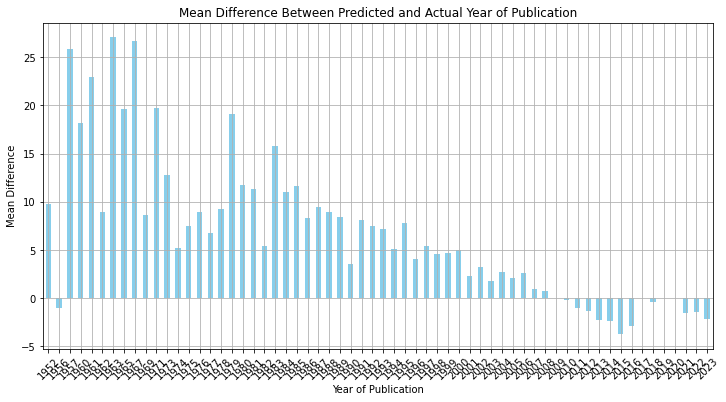

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the differences
differences = y_val_pred_random_forest - y_val

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({'Actual Year': y_val, 'Difference': differences})

# Group by the actual year and calculate mean difference
yearly_difference = analysis_df.groupby('Actual Year')['Difference'].mean()

# Plotting
plt.figure(figsize=(12, 6))
yearly_difference.plot(kind='bar', color='skyblue')
plt.title('Mean Difference Between Predicted and Actual Year of Publication')
plt.xlabel('Year of Publication')
plt.ylabel('Mean Difference')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

*3.4.2 Hyperparemeter tuning*

In [202]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# import warnings
# warnings.filterwarnings('ignore')

# # Define the parameter grid
# rf_params = {
#     'n_estimators': [100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2]  # Minimum number of samples required at each leaf node
# }

# # Initialize the Random Forest Regressor model
# random_forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# # Initialize the GridSearchCV object
# rf_grid_search = GridSearchCV(random_forest_reg, rf_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# # Perform the grid search on the training data
# rf_grid_search.fit(X_train, y_train)

# # Get the best parameters and the best MAE score
# rf_best_params = rf_grid_search.best_params_
# rf_best_score = -rf_grid_search.best_score_

# # Output the best parameters and best score
# print(f"Best parameters: {rf_best_params}")
# print(f"Best MAE score from CV: {rf_best_score}")

# # Evaluate the best model on the validation set
# best_random_forest_reg = rf_grid_search.best_estimator_
# y_val_pred_best_rf = best_random_forest_reg.predict(X_val)
# mae_best_rf = mean_absolute_error(y_val, y_val_pred_best_rf)
# print(f"MAE on validation set: {mae_best_rf}")

*with optimal parameters*

In [203]:
# # Instantiate the Random Forest Regressor with the best parameters
# optimized_random_forest_reg = RandomForestRegressor(
#     n_estimators=1001,
#     max_depth=None,  # or you can simply omit this since None is the default value
#     min_samples_leaf=1,
#     min_samples_split=5,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the model on your training data
# optimized_random_forest_reg.fit(X_train, y_train)

# # Make predictions on the validation set
# y_val_pred_opt_rf = optimized_random_forest_reg.predict(X_val)

# # Calculate the MAE on the validation set
# mae_opt_rf = mean_absolute_error(y_val, y_val_pred_opt_rf)

# # Output the MAE for the optimized Random Forest
# print(f"MAE for the optimized Random Forest: {mae_opt_rf}")

MAE: ***3.391160830483668***

*3.5 XGBoost*

In [204]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Initialize the XGBoost Regressor model
xgb_reg = XGBRegressor(random_state=42, n_jobs=-1)

# Train the model on the training data
xgb_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_xgb = xgb_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set for XGBoost Regression
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)

# Print the MAE for the XGBoost
print(f"MAE for the XGBoost: {mae_xgb}")

MAE for the XGBoost: 3.584449673733454


In [186]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error

# # Define the parameter grid
# xgb_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.8, 1],
#     'colsample_bytree': [0.8, 1],
# }

# # Initialize the XGBRegressor
# xgb_reg = XGBRegressor(random_state=42)

# # Initialize the GridSearchCV object
# xgb_grid_search = GridSearchCV(xgb_reg, xgb_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# # Fit the grid search to the data
# xgb_grid_search.fit(X_train, y_train)

# # Get the best parameters and the best MAE score
# xgb_best_params = xgb_grid_search.best_params_
# xgb_best_score = -xgb_grid_search.best_score_

# # Output the best parameters and best score
# print(f"Best parameters: {xgb_best_params}")
# print(f"Best MAE score from CV: {xgb_best_score}")

# # Evaluate the best model on the validation set
# best_xgb_reg = xgb_grid_search.best_estimator_
# y_val_pred_best_xgb = best_xgb_reg.predict(X_val)
# mae_best_xgb = mean_absolute_error(y_val, y_val_pred_best_xgb)
# print(f"MAE on validation set: {mae_best_xgb}")

In [187]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Instantiate the XGBRegressor with the best parameters
optimized_xgb_reg = XGBRegressor(
    colsample_bytree=1,
    learning_rate=0.3,
    max_depth=7,
    n_estimators=300,
    subsample=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model on your training data
optimized_xgb_reg.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_opt_xgb = optimized_xgb_reg.predict(X_val)

# Calculate the MAE on the validation set
mae_opt_xgb = mean_absolute_error(y_val, y_val_pred_opt_xgb)

# Output the MAE for the optimized XGBoost
print(f"MAE for the optimized XGBoost: {mae_opt_xgb}")

MAE for the optimized XGBoost: 3.4526167548879236


MAE: ***3.5603743764904374***

*3.6 Support Vector Machines*

In [188]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Initialize the Support Vector Regressor model
svr_reg = SVR()

# Train the model on the training data
svr_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_svr = svr_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set for Support Vector Regression
mae_svr = mean_absolute_error(y_val, y_val_pred_svr)

# Print the MAE for the SVM model
print(f"MAE for the SVM model: {mae_svr}")

MAE for the SVM model: 5.157961668388224


*3.6.2 Parameter tuning*

In [189]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error

# # Define the parameter grid to search
# svr_params = {
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf', 'linear'],  # You can also try 'poly' and 'sigmoid'
#     'gamma': ['scale', 'auto'],   # 'scale' uses 1 / (n_features * X.var()) as value of gamma
#     # 'epsilon': [0.01, 0.1, 0.5], Uncomment if you want to include epsilon in the tuning
# }

# # Initialize the SVR model
# svr_reg = SVR()

# # Initialize the GridSearchCV object
# svr_grid_search = GridSearchCV(svr_reg, svr_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# # Fit the grid search to the data
# svr_grid_search.fit(X_train, y_train)

# # Get the best parameters and the best MAE score
# svr_best_params = svr_grid_search.best_params_
# svr_best_score = -svr_grid_search.best_score_

# # Output the best parameters and best score
# print(f"Best parameters: {svr_best_params}")
# print(f"Best MAE score from CV: {svr_best_score}")

# # Evaluate the best model on the validation set
# best_svr_reg = svr_grid_search.best_estimator_
# y_val_pred_best_svr = best_svr_reg.predict(X_val)
# mae_best_svr = mean_absolute_error(y_val, y_val_pred_best_svr)
# print(f"MAE on validation set: {mae_best_svr}")

*3.6 Neural network*

In [190]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Initialize the Multi-layer Perceptron Regressor model
# Adjust the hidden_layer_sizes according to the complexity of your problem
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Train the model on the training data
mlp_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_mlp = mlp_reg.predict(X_val)

# Calculate the Mean Absolute Error on the validation set for MLP Regression
mae_mlp = mean_absolute_error(y_val, y_val_pred_mlp)

# Print the MAE for the MLP model
print(f"MAE for the MLP model: {mae_mlp}")

MAE for the MLP model: 4.306213620207791


*3.6.2 Parameter tuning*

In [191]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error

# # Define the parameter grid to search
# mlp_params = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
#     'learning_rate': ['constant', 'adaptive'],
# }

# # Initialize the MLPRegressor
# mlp_reg = MLPRegressor(max_iter=1000, random_state=42)

# # Initialize the GridSearchCV object
# mlp_grid_search = GridSearchCV(mlp_reg, mlp_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# # Fit the grid search to the data
# mlp_grid_search.fit(X_train, y_train)

# # Get the best parameters and the best MAE score
# mlp_best_params = mlp_grid_search.best_params_
# mlp_best_score = -mlp_grid_search.best_score_

# # Output the best parameters and best score
# print(f"Best parameters: {mlp_best_params}")
# print(f"Best MAE score from CV: {mlp_best_score}")

# # Evaluate the best model on the validation set
# best_mlp_reg = mlp_grid_search.best_estimator_
# y_val_pred_best_mlp = best_mlp_reg.predict(X_val)
# mae_best_mlp = mean_absolute_error(y_val, y_val_pred_best_mlp)
# print(f"MAE on validation set: {mae_best_mlp}")

**Step 4: Model Comparison**

In [192]:
import pandas as pd

# Assuming you have MAE values for each model stored in variables
results = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'SuperVectorMachines'],
    'MAE': [mae_lin_reg, mae_decision_tree, mae_random_forest, mae_xgb, mae_svr]
}

results_df = pd.DataFrame(results)
results_df.sort_values(by='MAE', inplace=True)

print(results_df)

                 Model       MAE
2        Random Forest  3.374080
3              XGBoost  3.657469
0    Linear Regression  4.055139
1        Decision Tree  4.244435
4  SuperVectorMachines  5.157962


*4.2 Visualization*

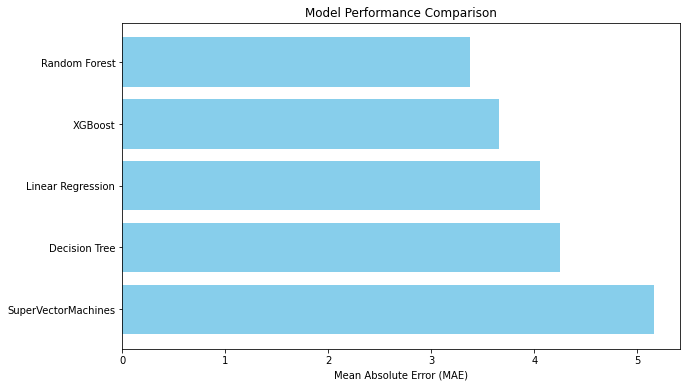

In [193]:
import matplotlib.pyplot as plt

# Create a bar chart for visual comparison
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['MAE'], color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('Model Performance Comparison')
plt.gca().invert_yaxis()  # To have the best model at the top
plt.show()

**Step 5:** Make predictions for the test set

In [194]:
from sklearn.ensemble import RandomForestRegressor

# Extract the target variable 'year' and features from the full training dataset
full_target = train_df_combined['year']
full_features = train_df_combined.drop('year', axis=1)

# Drop the 'year' column from the test dataset if it exists
if 'year' in test_df_combined.columns:
    test_df_combined = test_df_combined.drop('year', axis=1)

# Align the features of the test set with those of the training set
test_df_combined_aligned = test_df_combined.reindex(columns = full_features.columns, fill_value=0)

# Now, try realigning the test features
test_df_combined_aligned = test_df_combined.reindex(columns=full_features.columns, fill_value=0)

# Initialize the Random Forest Regressor with the best parameters found
random_forest_full = RandomForestRegressor(
    n_estimators=1500,
    max_depth=None,  # or you can simply omit this since None is the default value
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)  # Adjust parameters as needed

# Train the model on the full training data
random_forest_full.fit(full_features, full_target)

# Predict on the test dataset
test_predictions = random_forest_full.predict(test_df_combined_aligned)

KeyboardInterrupt: 

In [ ]:
len(test_df_combined_aligned)

21904

In [ ]:
import json

# Creating a list of dictionaries for submission
submission = [{'year': int(year)} for year in test_predictions]

# Saving the submission file
with open('predicted.json', 'w') as file:
    json.dump(submission, file)